In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

BASE_DIR = "/kaggle/input/100-bird-species"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [2]:
paths_df = pd.read_csv(os.path.join(BASE_DIR, "birds.csv"))
paths_df.drop(46620, axis= 0, inplace=True)
labels = paths_df["class id"].unique()
bird_name_map = {i: paths_df[paths_df["class id"] == i]["labels"].values[0] for i in labels}


In [3]:
paths_df.head()

class id                      filepaths           labels  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER   

       scientific label data set  
0  Malacocincla abbotti    train  
1  Malacocincla abbotti    train  
2  Malacocincla abbotti    train  
3  Malacocincla abbotti    train  
4  Malacocincla abbotti    train

In [4]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75125 entries, 0 to 75125
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   class id          75125 non-null  int64 
 1   filepaths         75125 non-null  object
 2   labels            75125 non-null  object
 3   scientific label  75125 non-null  object
 4   data set          75125 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [6]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        img_path = os.path.join(BASE_DIR, img_path)
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        label = self.df.iloc[idx]['class id']
        #convert label to a tensor
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [7]:
normalise_means = [0.4914, 0.4822, 0.4465]
normalise_stds = [0.2023, 0.1994, 0.2010]

train_transform = T.Compose([T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(normalise_means, normalise_stds),])

test_transforms = T.Compose([T.ToTensor(), T.Normalize(normalise_means, normalise_stds)])
    
train_df = paths_df[paths_df['data set'] == 'train']
test_df = paths_df[paths_df['data set'] == 'test']
val_df = paths_df[paths_df['data set'] == 'valid']

train_dataset = BirdDataset(train_df, train_transform)
test_dataset = BirdDataset(test_df, test_transforms)
val_dataset = BirdDataset(val_df, test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

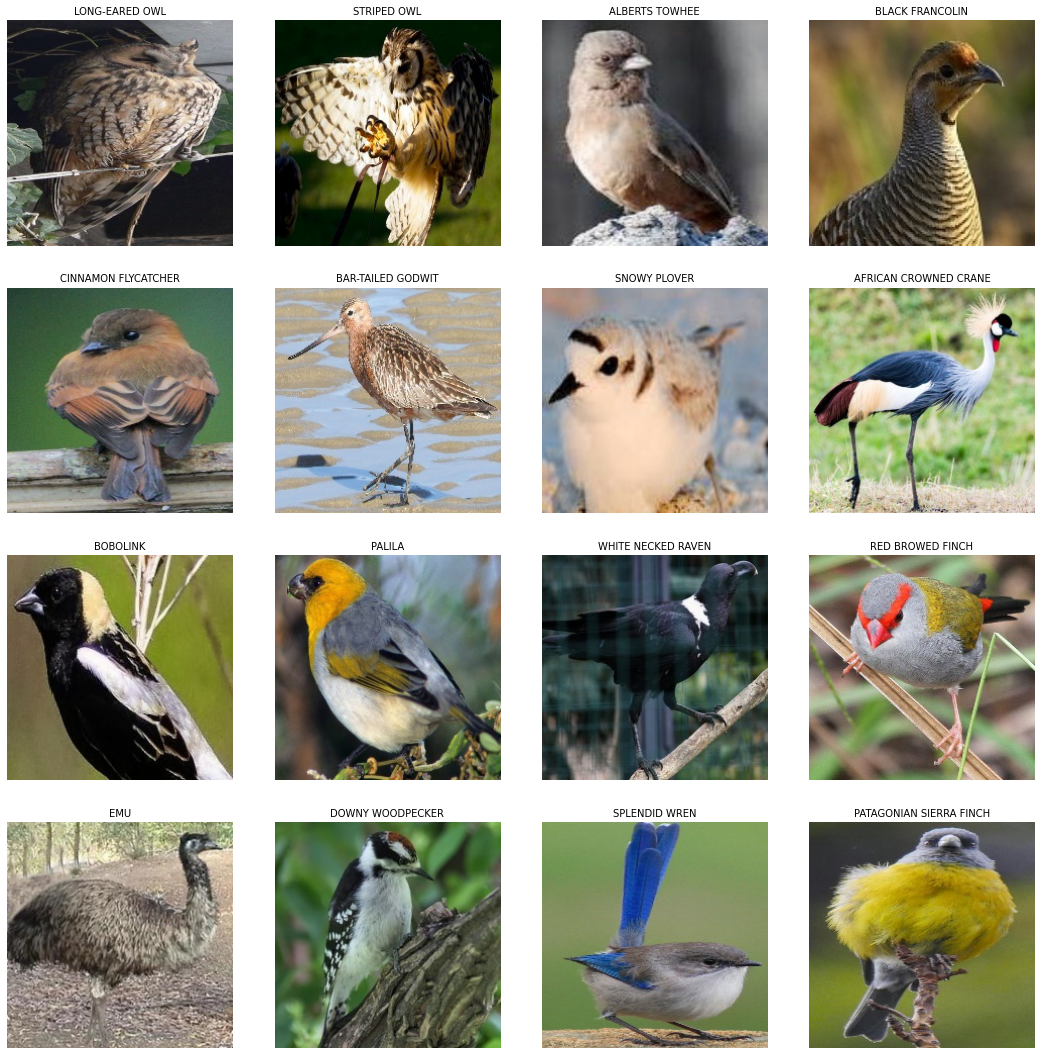

In [2]:
def denormalize(img):
    means = torch.tensor(normalise_means).view(3, 1, 1)
    stds = torch.tensor(normalise_stds).view(3, 1, 1)
    return img * stds + means

def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            image = denormalize(images[i*4 + j]).permute(1, 2, 0)
            label = labels[i*4 + j].item()
            ax[i][j].imshow((image.numpy() * 255).astype(np.uint8))
            title = class_map[label]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_loader))
show_batch(images, labels, bird_name_map)

In [9]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride= 1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride= stride, padding= 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride= 1, padding= 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace= True)

        self.downsample = nn.Sequential()
        
        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.downsample(x)

        out = self.relu(out)

        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3, 64, 7, stride= 2, padding= 3),
            nn.BatchNorm2d(64), nn.MaxPool2d(3, stride= 2, padding= 1))

        self.layer0 = self._make_layer(64, 64, 3, 1)
        self.layer1 = self._make_layer(64, 128, 4, 2)
        self.layer2 = self._make_layer(128, 256, 6, 2)
        self.layer3 = self._make_layer(256, 512, 3, 2)

        self.avg_pool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))

        for i in range(num_blocks - 1):
            layers.append(BasicBlock(out_channels, out_channels, 1))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        
        out = self.layer0(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        out = F.log_softmax(out, dim= 1)
        return out

In [10]:
def train(model, epochs, optimizer, criterion, scheduler, device, trainloader, valloader):

    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
        
    for i in tqdm(range(epochs)):
        running_loss = 0.0
        running_correct = 0
        total = 0

        for images, targets in trainloader:
            
            images, targets = images.to(device), targets.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = torch.argmax(output, dim=1)
        
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
        
        scheduler.step()

        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

        running_val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():

            for images, targets in valloader:
                images, targets = images.to(device), targets.to(device)

                output = model(images)
                preds = torch.argmax(output, dim=1)

                correct += (preds == targets).sum().item()
                running_val_loss += criterion(output, targets).item()
                total += targets.size(0)

            acc = correct / total
            val_acc.append(acc)
            val_losses.append(running_val_loss / len(valloader))

        print(f"Epoch: {i+1}, Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_acc[-1]:.3f}")

    return train_losses, train_acc, val_losses, val_acc

In [11]:
model = ResNet34(450).to(device)
model = model.to(device)
print(model)

ResNet34(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [12]:
epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)

train_losses, train_acc, val_losses, val_acc = train(model, epochs, optimizer, criterion, scheduler, device, train_loader, val_loader)
print("  Finished Training  ")

  7%|▋         | 1/15 [06:20<1:28:49, 380.70s/it]

Epoch: 1, Train Loss: 4.526, Train Acc: 0.105, Val Loss: 2.913, Val Acc: 0.312


 13%|█▎        | 2/15 [10:57<1:09:13, 319.50s/it]

Epoch: 2, Train Loss: 2.492, Train Acc: 0.410, Val Loss: 1.697, Val Acc: 0.574


 20%|██        | 3/15 [15:35<1:00:05, 300.49s/it]

Epoch: 3, Train Loss: 1.603, Train Acc: 0.605, Val Loss: 1.100, Val Acc: 0.716


 27%|██▋       | 4/15 [20:09<53:11, 290.14s/it]  

Epoch: 4, Train Loss: 1.158, Train Acc: 0.707, Val Loss: 0.765, Val Acc: 0.794


 33%|███▎      | 5/15 [24:47<47:36, 285.63s/it]

Epoch: 5, Train Loss: 0.892, Train Acc: 0.771, Val Loss: 0.682, Val Acc: 0.812


 40%|████      | 6/15 [29:32<42:50, 285.60s/it]

Epoch: 6, Train Loss: 0.695, Train Acc: 0.820, Val Loss: 0.529, Val Acc: 0.856


 47%|████▋     | 7/15 [34:05<37:30, 281.27s/it]

Epoch: 7, Train Loss: 0.538, Train Acc: 0.858, Val Loss: 0.478, Val Acc: 0.869


 53%|█████▎    | 8/15 [38:39<32:34, 279.16s/it]

Epoch: 8, Train Loss: 0.413, Train Acc: 0.891, Val Loss: 0.385, Val Acc: 0.896


 60%|██████    | 9/15 [43:19<27:55, 279.26s/it]

Epoch: 9, Train Loss: 0.313, Train Acc: 0.918, Val Loss: 0.361, Val Acc: 0.898


 67%|██████▋   | 10/15 [48:18<23:46, 285.37s/it]

Epoch: 10, Train Loss: 0.218, Train Acc: 0.945, Val Loss: 0.321, Val Acc: 0.911


 73%|███████▎  | 11/15 [52:47<18:41, 280.29s/it]

Epoch: 11, Train Loss: 0.157, Train Acc: 0.962, Val Loss: 0.292, Val Acc: 0.915


 80%|████████  | 12/15 [57:19<13:53, 277.92s/it]

Epoch: 12, Train Loss: 0.110, Train Acc: 0.977, Val Loss: 0.288, Val Acc: 0.918


 87%|████████▋ | 13/15 [1:02:18<09:28, 284.37s/it]

Epoch: 13, Train Loss: 0.083, Train Acc: 0.985, Val Loss: 0.269, Val Acc: 0.924


 93%|█████████▎| 14/15 [1:06:49<04:40, 280.36s/it]

Epoch: 14, Train Loss: 0.070, Train Acc: 0.989, Val Loss: 0.260, Val Acc: 0.924


100%|██████████| 15/15 [1:11:20<00:00, 285.35s/it]

Epoch: 15, Train Loss: 0.067, Train Acc: 0.991, Val Loss: 0.254, Val Acc: 0.927
  Finished Training  


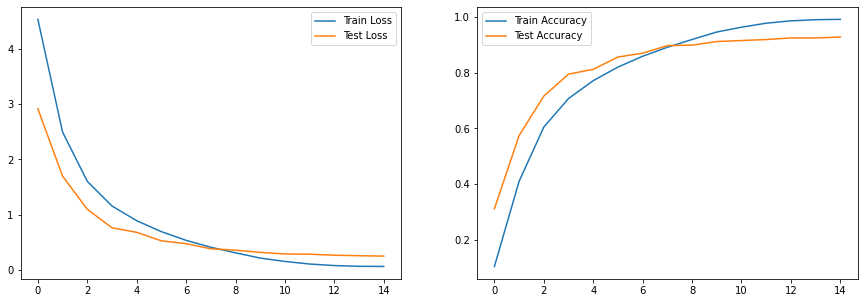

In [13]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

plot_graphs(train_losses, train_acc, val_losses, val_acc)

In [14]:
def test(model, testloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in testloader:
            images, targets = images.to(device), targets.to(device)
            output = model(images)
            preds = torch.argmax(output, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    print(f"Test Accuracy: {correct / total:.3f}")

test(model, test_loader, device)

Test Accuracy: 0.939


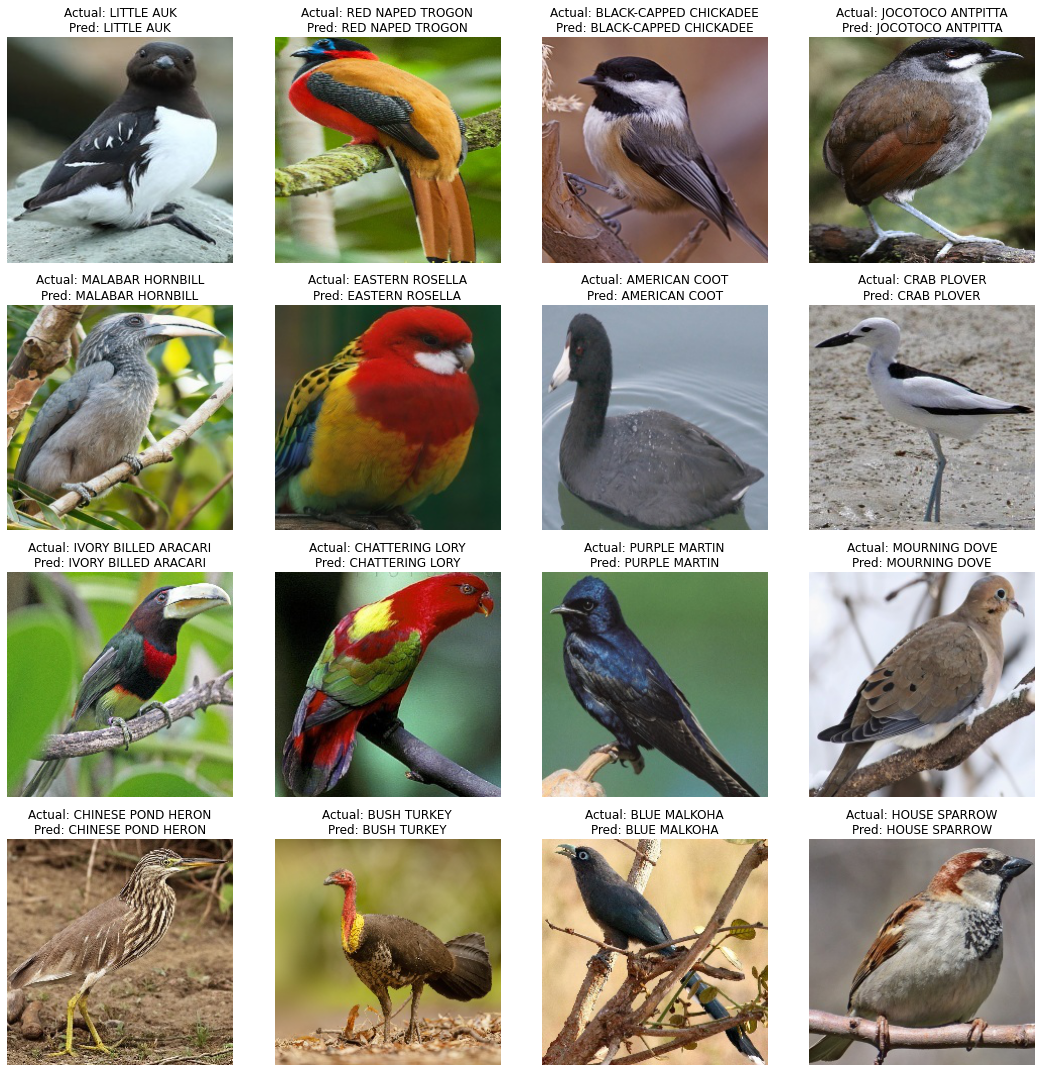

In [5]:
def show_test_batch(images, preds, targets, class_map):
    images = denormalize(images.cpu())
    images = images.numpy()
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.transpose(images[i*4+j], (1, 2, 0)))
            ax[i, j].set_title(f"Actual: {class_map[targets[i*4+j]]}\nPred: {class_map[preds[i*4+j]]}")
            ax[i, j].axis("off")

images, targets = next(iter(test_loader))
images, targets = images.to(device), targets.to(device)
output = model(images)
preds = torch.argmax(output, dim=1)

show_test_batch(images, preds, targets, bird_name_map)

In [16]:
torch.save(model.state_dict(), 'birds_resnet34_model.pth')

In [17]:
from IPython.display import FileLink
FileLink(r'birds_resnet34_model.pth')

/kaggle/working/birds_resnet34_model.pth